## Differentiated Sand Silt Clay Fraction Analysis

Use this notebook when computing BOEM samples where the sand fraction was not mechanically (dry) sieved to partition into predetermined size classes. Only bulk sand, silt, and clay fraction weights compiled and reported.

### Bureau of Ocean Energy and Management (BOEM) - North Carolina Offshore Sand Resources

In this notebook we conduct an exploratory analysis of sediment samples collected at various locations on the seabed off the North Carolina coast. Sample data includes cores and [maybe?] surface grab samples.

**Sample Processing Methodology$^1$:**

- 40-50 g subsample disaggregated in 0.5% sodium hexametaphosphate $(NaPO_3)_6$ soln.
- Subsample sonicated to disperse $< 63\mu m$ fraction
- Subsample partitioned into coarse/fine components via 0.5% $(NaPO_3)_6$ wash through $63\mu m$ sieve
- Sediment $< 63\mu m$ captured in >= 500 ml $(NaPO_3)_6$ soln.; 20 ml aliquots drawn at t=0 and t=1hr
- Aliquots dried, weighed, and recorded
- Sediment $>= 63\mu m$ dried, weighed, and recorded$^2$.

$^1$Process applies to samples containing sediment of all sizes <br/>
$^2$Sand fraction not dry sieved

### 0.) Load Requisite Libraries, Modules, and other vittles...

In [74]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

sys.path.append('/Users/paulp/GoogleDrive/projects/SedSAS/')
import SedSASClass

### 1.) Enter identifier (id) for current core or sample site to be processed:

In [75]:
id='VC27'     # <<<<<< IMPORTANT!     'VC06', 'VC09', '', ''

### 2.) Load the raw sieve results from the [an existing] db and merge to single dataframe df:

In [76]:
fp='/Users/paulp/GoogleDrive/projects/BOEM/boemCoreAnaql.db'

con=sqlite3.connect(fp)
df_1 = pd.read_sql_query("SELECT * from "+id+"_DrySieveResults", con)
df_2 = pd.read_sql_query("SELECT * from "+id+"_PipetteResults", con)
con.close()

# merge the two dataframes, adding the columns of df_1 to df_2 to create our base working dataframe df:
df=df_1.merge(df_2, left_on='Position', right_on='Position', how='inner')
df=df.replace('',np.nan).fillna(0)          # fill blank fields with NaN

### 3.) Since the sand fraction was not sieved we will assume that, for the purpose of computing total slit and clay fraction weights, the dryfines 'bin' = 0

The dryfines are the sediment in a sample that falls through all to the pan positioned at the bottom of the sieve stack

The remainder of the sieve weight classes (phi size columns) are ignored in this notebook.

In [33]:
#df['dryfines']=0.0
#df['dryfines'] = df['dryfines'].apply(pd.to_numeric)

### 4.) Subtract the Weight of the Weighing Pans from the Dried Sampling Weights:

This yields the weight of the dried uncorrected 20 ml aliquot pipetted at time = 20s, and...<br/>
...the weight of the dried uncorrected 20 ml aliquot pipetted at time = 1 hour

In [77]:
df['SampleWt_1stDraw'] = df['SampleWt_1stDraw']-df['PanWt_1stDraw']
df['SampleWt_2ndDraw'] = df['SampleWt_2ndDraw']-df['PanWt_2ndDraw']
#df

### 5.) Compute Sodium Hexametaphosphate dispersant wash residue weight correction for the dried pipette samples


Residue left behind as an evaporite in the dried pipette samples must be accounted for in computing the weight and weight percentages for the drawn silt / clay aliquots. 

NaPO3 mixed in bulk to concentration: 5 gm dry powder to 1 L DDI water used for sediment wash

Note that this correction is not applied to the sand and coarser fraction weights


Note 2 that we are for the moment compensating for measurement error where the total weight of the sample+dispersant-pan weight is less than the weight of dispersant (which should be present) alone. In these instances, the sample draw weight is set to equal 0.

In [78]:
NaPO3=5           # conc (NaPO3)6 in 1 L H2O (in grams)
aliquot=20        # pipette sample volume (in ml)

# (NaPO3*df['Cyl_Vol'] / 1000 )   -->  weight in grams of NaPO3 in cylinder (proportion based on conc and cyl volume)
#                                 -->  NaPO3/1000 = mixed reference conc of dispersant
# ( aliquot /df['Cyl_Vol'] )      -->  ratio of sample aliquot to cyl vol. Adj. to determine total sediment wt in 
#                                      cylinder. Aliquot represents volume subset of assumed homogeneous suspension
#
# Note that with a 5g/L conc of NaPO3 we end up with a weight of 0.1 gms NaPO3 / 20 ml aliquot

df['SampleWt_1stDraw']=df['SampleWt_1stDraw'] - (NaPO3*df['Cyl_Vol'] / 1000 )*( aliquot /df['Cyl_Vol'] )
df['SampleWt_2ndDraw']=df['SampleWt_2ndDraw'] - (NaPO3*df['Cyl_Vol'] / 1000 )*( aliquot /df['Cyl_Vol'] )
#print(df['SampleWt_1stDraw'], df['SampleWt_2ndDraw'])

### though both the first and second draw sample weights should always be > or = the
### weight of the dispersant in soln in the aliquot, it sometimes happens that 
### this is not the case. For now, our only recourse is to detect these instances and
### compensate by setting the draw weight(s) to 0 and proceeding as if there is no
### clay and or silt in the sample.
df['SampleWt_1stDraw'] = np.where(df['SampleWt_1stDraw'] < 0.0, 0, df['SampleWt_1stDraw'] )
df['SampleWt_2ndDraw'] = np.where(df['SampleWt_2ndDraw'] < 0.0, 0, df['SampleWt_2ndDraw'] ) 
#df

### 6.) Apply Volumetric Correction for Pipette Sample

These computations yield the final adjusted weights of all the fines (20 sec immediate draw), and (after 1 hour) all the fines >= 6$\phi$, respectively, in the graduated cylinder

In [79]:
df['SampleWt_1stDraw']=df['SampleWt_1stDraw'] * ( df['Cyl_Vol']/aliquot )
df['SampleWt_2ndDraw']=df['SampleWt_2ndDraw'] * ( df['Cyl_Vol']/aliquot )
#df

### 7.) Compute the particle-size fraction weights:

From the raw weights provided in the pipette results compute the raw bulk weights for:
- Gravels (<= -2$\phi$)   GravelWt = df['phi_n225']
- Sands(-1$\phi$ >= s <= 4$\phi$) = df['phi_n10'] to df['phi_4']
- Silts (> 4$\phi$ - ~<= 6$\phi$):   = TotalFinesWt - ClayWt
- Clays (~<6$\phi$):   = Corrected SampleWt_2ndDraw
- Total Fines (Silts + Clays):  = Corrected SampleWt_1stDraw + dryfines


Note that we are combining the fines collected during the dry sieving process with those sampled from the pipette/settling procedure to compute the total fines for the sample. If the sand fraction was not dry sieved then the fine component contributed by the sand (dryfines) is set equal to 0

In [83]:
### the gravel fraction:
df['GravelWt']=df['phi_n225']+df['phi_n1'] 

### sand weight is based on either: 1.) the total weight of material captured in the sieves smaller (aperture) 
### than -1 phi if the sample was dry sieved, or, 2.) if not dry sieved the resultant of the dry sand wt captured
### in the 63 um sieve during the wet sieve process less the weight of the containing dish, and any weight contained
### in the gravel and pan fines fractions The latter is unlikely, but just in case...
drySieved_wt=df.iloc[:,5:15].sum(axis=1)   # weight of sieved sand fraction (-0.5 phi to 4 phi, inclusive)
wetSieved_wt=df['Dry_wt']-df['Pan_wt']-df['GravelWt'] - df['dryfines']
df['SandWt'] = np.where( drySieved_wt != 0, drySieved_wt, wetSieved_wt)

### the fine fraction (silt and clay):
df['TotalFinesWt']=df['SampleWt_1stDraw']+df['dryfines'].astype(float)
df['ClayWt']=df['SampleWt_2ndDraw']
df['SiltWt']=df['TotalFinesWt']-df['ClayWt']

### the total weight of the sample being analyzed:
df['TotalWt']=df['TotalFinesWt']+df['SandWt']+df['GravelWt']

In [82]:
drySieved_wt=df.iloc[:,5:15].sum(axis=1)   # weight of sieved sand fraction (-0.5 phi to 4 phi, inclusive)
wetSieved_wt=df['Dry_wt']-df['Pan_wt']-df['GravelWt'] - df['dryfines']
df['SandWt'] = np.where( drySieved_wt != 0, drySieved_wt, wetSieved_wt)
print( drySieved_wt, wetSieved_wt, df['SandWt'] )

0     36.98
1     32.40
2     32.64
3     37.61
4     34.83
5      0.00
6      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
12     0.00
13     0.00
14    16.97
15    17.96
16    29.57
17    33.19
18    31.47
dtype: float64 0     36.76
1     32.32
2     32.41
3     38.69
4     35.14
5     30.05
6     29.46
7     24.21
8      4.58
9      1.49
10     1.76
11    29.92
12    29.64
13    33.02
14    17.04
15    17.92
16    29.47
17    33.08
18    29.07
dtype: float64 0     36.98
1     32.40
2     32.64
3     37.61
4     34.83
5     30.05
6     29.46
7     24.21
8      4.58
9      1.49
10     1.76
11    29.92
12    29.64
13    33.02
14    16.97
15    17.96
16    29.57
17    33.19
18    31.47
Name: SandWt, dtype: float64


### 8.) Compute the particle size weight percentages and cumulative weight percentages: 

results to be used in building the frequency plot that follows.

In [84]:
####### IMPORTANT
df['GravelWtPct']=(df['GravelWt'] / df['TotalWt'])*100
df['SandWtPct']=(df['SandWt'] / df['TotalWt'])*100
df['SiltWtPct']=(df['SiltWt'] / df['TotalWt'])*100
df['ClayWtPct']=(df['ClayWt'] / df['TotalWt'])*100

### Add computed fields for cumulative weight percent coarse+sand and coarse+sand+fines (the latter which is 
### 100% in all cases). We use the latter as a boundary for the area fill on the cumulative plot (subplot #4) 
### to come:
df['BaselineWtPct']=0
df['GSCumWtPct']=df['GravelWtPct']+df['SandWtPct']     # accumulated gravels + sands
df['GSiCumWtPct']=df['GravelWtPct']+df['SandWtPct']+df['SiltWtPct']   # accumulated gravels+sands+silts
df['SSCCumWtPct']=df['GSiCumWtPct']+df['ClayWtPct']   # accumulated gravels+sands+silts+clays  (should be 100%)

### Important: Check for Percent Total Fines...

If total fines exceed 5%, report on Cumulative Weight Percent plot on Sed Log, then scream loudly!

In [39]:
#df['TotalFinesWt']/df['TotalWt']*100
#df

### 9.) Create, Display, and Save Filled Cumulative Size Fraction Graphic

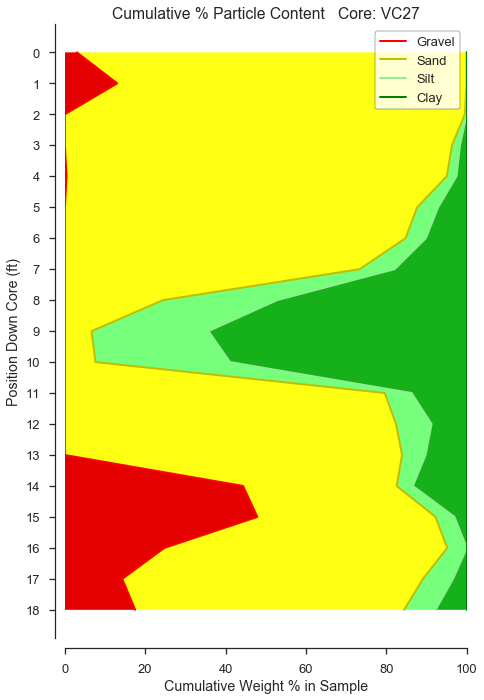

In [86]:
#  PLOT PERCENT CUMULATIVE SIZE FRACTIONS per sample site:

sns.set_style('ticks')
sns.set_context('talk')

ytics=[0,1,2,3,4,5,6,7,8,9,10,11,12]  #[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
yticlbls=['0','1','2','3','4','5','6','7','8','9','10','11','12']
figh, axh = plt.subplots(nrows=1, ncols=1, figsize=(7,10))   #sharey='row'


axh.plot(df['GravelWtPct'], df['Position'], 'r-', label='Gravel', linewidth=2 )
axh.plot(df['GSCumWtPct'], df['Position'], 'y-', label='Sand', linewidth=2 )
axh.plot(df['GSiCumWtPct'], df['Position'], '-', label='Silt', color='lightgreen', linewidth=2 )
axh.plot(df['SSCCumWtPct'], df['Position'], 'g-', label='Clay', linewidth=2 )

axh.fill_betweenx( df['Position'],df['BaselineWtPct'], df['GravelWtPct'],  facecolor='xkcd:red')
axh.fill_betweenx( df['Position'],df['GravelWtPct'], df['GSCumWtPct'],  facecolor='xkcd:yellow')
axh.fill_betweenx( df['Position'],df['GSCumWtPct'], df['GSiCumWtPct'],  facecolor='xkcd:lightgreen')
axh.fill_betweenx( df['Position'],df['GSiCumWtPct'], df['SSCCumWtPct'],  facecolor='xkcd:green')
labels=['Gravel','Sand','Silt','Clay']
colors=['Red','Yellow','lightgreen','Blue']

sns.despine(offset=10, top=True, right=True, ax=axh)
axh.invert_yaxis()
axh.set_xlim(0,100)
#axh3.set_xticks([0,25,50,75,100])
#axh.set_yticks( [x for x in range(len(df) ) ] )
axh.set_yticks(df['Position'].tolist())
axh.set_xlabel('Cumulative Weight % in Sample')
axh.set_ylabel('Position Down Core (ft)')

leg=axh.legend(loc='best', frameon=True )     ### for VC01:(0.4,0.3) ; for VC27:  ; VC10 and VC37: (0.3,0.37)
frm=leg.get_frame()
frm.set_facecolor('white')
frm.set_edgecolor('black')

axh.set_title('Cumulative % Particle Content'+'   Core: '+id )


plt.tight_layout()
#figh.suptitle('Vibracore 06', fontsize=20)

plt.savefig('/Users/paulp/GoogleDrive/projects/BOEM/graphics/wetSievedOnlyCores/sed_log_'+id+'_fillSSC.pdf')

In [41]:
df.Position.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

### 10.) Generate Grain-Size Analysis Plots for Core Samples:  (Not currently in use)

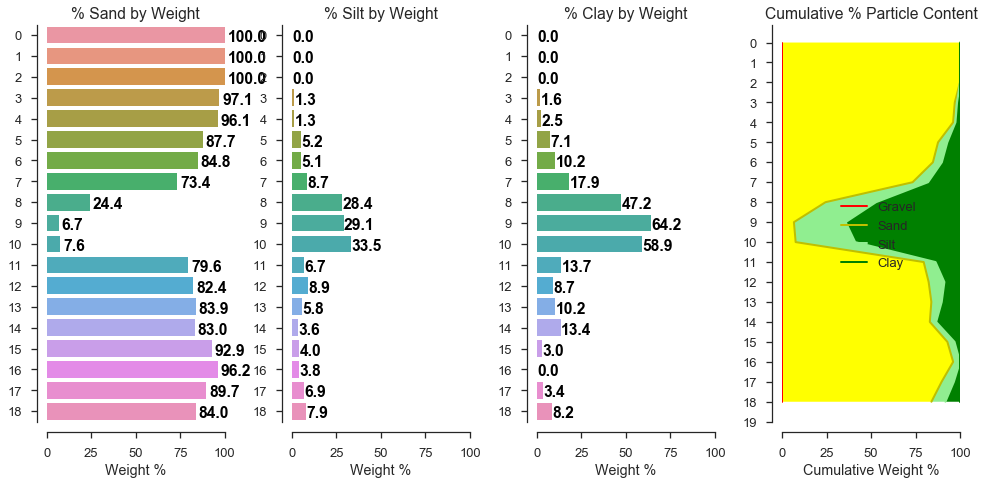

In [42]:
sns.set_style('ticks')
sns.set_context('talk')

#xtics=[-2.25,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0]
#xticlbls=['-2.25','-1.0','-0.5','0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','>4']
ytics=[0,1,2,3,4,5,6,7,8,9,10,11,12]
yticlbls=['0','1','2','3','4','5','6','7','8','9','10','11','12']
figh, (axh0, axh1, axh2, axh3) = plt.subplots(nrows=1, ncols=4, figsize=(14,7))   #sharey='row'


#  SUBLOT #0: PERCENT SAND FRACTION per sample site:
sns.barplot(x='SandWtPct',  y='Position', data=df, orient='h', ax=axh0)
#axh0.plot(df['SandWtPct'], df['Position'], '--o', c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh0)
axh0.set_xlim(0,100)
#axh0.invert_yaxis()
axh0.set_xlabel('Weight %')
axh0.set_ylabel('')
axh0.set_title('% Sand by Weight')

for i, v in enumerate(df['SandWtPct']):
    axh0.text(v + 1.5, i+0.3, str(round(v,1)), color='black', fontweight='bold')
    
    
#  SUBLOT #1: PERCENT SILT FRACTION per sample site:
sns.barplot(x='SiltWtPct',  y='Position', data=df, orient='h', ax=axh1)
#axh1.plot(df['SiltWtPct'], df['Position'], '--o', c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh1)
axh1.set_xlim(0,100)
#axh1.invert_yaxis()
axh1.set_xlabel('Weight %')
axh1.set_ylabel('')
axh1.set_title('% Silt by Weight')

for i, v in enumerate(df['SiltWtPct']):
    axh1.text(v+0.25, i+0.3, str(round(v,1)), color='black', fontweight='bold')
    

#  SUBLOT #1: PERCENT CLAY FRACTION per sample site:
sns.barplot(x='ClayWtPct',  y='Position', data=df, orient='h', ax=axh2)
#axh2.plot(df['ClayWtPct'], df['Position'], '--o', c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh2)
axh2.set_xlim(0,100)
#axh2.invert_yaxis()
axh2.set_xlabel('Weight %')
axh2.set_ylabel('')
axh2.set_title('% Clay by Weight')

for i, v in enumerate(df['ClayWtPct']):
    axh2.text(v+0.25, i+0.3, str(round(v,1)), color='black', fontweight='bold')
    
    
#  SUBLOT #4: PERCENT CUMULATIVE SIZE FRACTIONS per sample site:
#sns.barplot(x='FinesWtPct',  y='Position', data=df, orient='h', ax=axh3)
axh3.plot(df['GravelWtPct'], df['Position'], 'r-', label='Gravel', linewidth=2 )
axh3.plot(df['GSCumWtPct'], df['Position'], 'y-', label='Sand', linewidth=2 )
axh3.plot(df['GSiCumWtPct'], df['Position'], '-', label='Silt', color='lightgreen', linewidth=2 )
axh3.plot(df['SSCCumWtPct'], df['Position'], 'g-', label='Clay', linewidth=2 )

axh3.fill_betweenx( df['Position'],df['BaselineWtPct'], df['GravelWtPct'],  facecolor='Red')
axh3.fill_betweenx( df['Position'],df['GravelWtPct'], df['GSCumWtPct'],  facecolor='yellow')
axh3.fill_betweenx( df['Position'],df['GSCumWtPct'], df['GSiCumWtPct'],  facecolor='lightgreen')
axh3.fill_betweenx( df['Position'],df['GSiCumWtPct'], df['SSCCumWtPct'],  facecolor='green')
labels=['Gravel','Sand','Silt','Clay']
colors=['Red','Yellow','lightgreen','Blue']

sns.despine(offset=10, top=True, right=True, ax=axh3)
axh3.invert_yaxis()
axh3.set_xlim(0,100)
#axh3.set_xticks([0,25,50,75,100])
axh3.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axh3.set_xlabel('Cumulative Weight %')
axh3.set_ylabel('')
axh3.legend(loc=(0.3,0.37) )     ### for VC01:(0.4,0.3) ; for VC27:  ; VC10 and VC37: (0.3,0.37)
axh3.set_title('Cumulative % Particle Content')


plt.tight_layout()
#figh.suptitle('Vibracore 06', fontsize=20)

### plt.savefig('/Users/paulp/GoogleDrive/projects/BOEM/graphics/sed_log_'+id+'_barSSC.pdf')

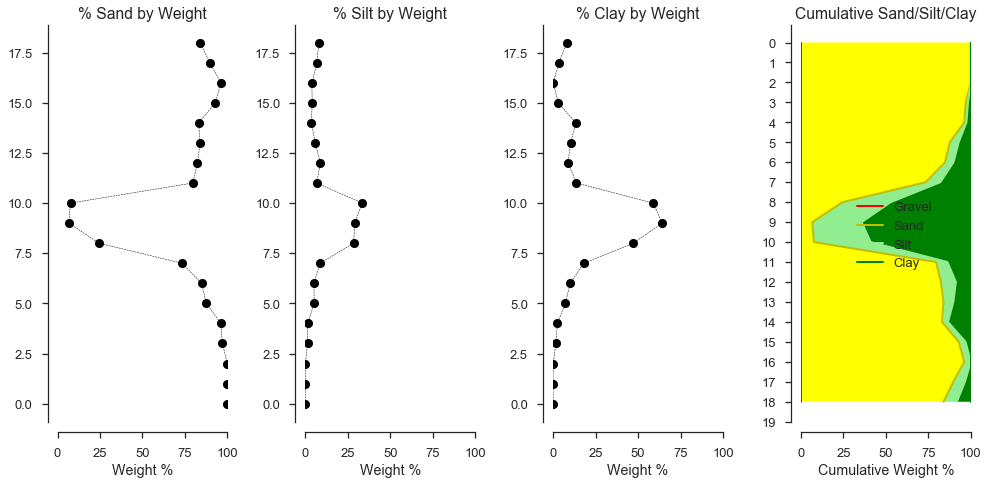

In [43]:
sns.set_style('ticks')
sns.set_context('talk')

#xtics=[-2.25,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0]
#xticlbls=['-2.25','-1.0','-0.5','0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','>4']
ytics=[0,1,2,3,4,5,6,7,8,9,10,11,12]
yticlbls=['0','1','2','3','4','5','6','7','8','9','10','11','12']
figh, (axh0, axh1, axh2, axh3) = plt.subplots(nrows=1, ncols=4, figsize=(14,7))   #sharey='row'


#  SUBLOT #0: PERCENT SAND FRACTION per sample site:
#sns.barplot(x='SandWtPct',  y='Position', data=df, orient='h', ax=axh0)
axh0.plot(df['SandWtPct'], df['Position'], '--o', linewidth=0.5, c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh0)
axh0.set_xlim(0,100)
#axh0.invert_yaxis()
axh0.set_xlabel('Weight %')
axh0.set_ylabel('')
axh0.set_title('% Sand by Weight')

#for i, v in enumerate(df['SandWtPct']):
#    axh0.text(v - 4, i-0.3, str(round(v,1)), color='black', fontweight='bold')
    
    
#  SUBLOT #1: PERCENT SILT FRACTION per sample site:
#sns.barplot(x='SiltWtPct',  y='Position', data=df, orient='h', ax=axh1)
axh1.plot(df['SiltWtPct'], df['Position'], '--o',  linewidth=0.5, c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh1)
axh1.set_xlim(0,100)
#axh1.invert_yaxis()
axh1.set_xlabel('Weight %')
axh1.set_ylabel('')
axh1.set_title('% Silt by Weight')

#for i, v in enumerate(df['SiltWtPct']):
#    axh1.text(v+0.035, i-0.3, str(round(v,1)), color='black', fontweight='bold')
    

#  SUBLOT #1: PERCENT CLAY FRACTION per sample site:
#sns.barplot(x='ClayWtPct',  y='Position', data=df, orient='h', ax=axh2)
axh2.plot(df['ClayWtPct'], df['Position'], '--o', linewidth=0.5, c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh2)
axh2.set_xlim(0,100)
#axh2.invert_yaxis()
axh2.set_xlabel('Weight %')
axh2.set_ylabel('')
axh2.set_title('% Clay by Weight')

#for i, v in enumerate(df['ClayWtPct']):
#    axh2.text(v+0.035, i-0.3, str(round(v,1)), color='black', fontweight='bold')
    
    
#  SUBLOT #4: PERCENT CUMULATIVE SIZE FRACTIONS per sample site:
#sns.barplot(x='FinesWtPct',  y='Position', data=df, orient='h', ax=axh3)
axh3.plot(df['GravelWtPct'], df['Position'], 'r-', label='Gravel', linewidth=2 )
axh3.plot(df['GSCumWtPct'], df['Position'], 'y-', label='Sand', linewidth=2 )
axh3.plot(df['GSiCumWtPct'], df['Position'], '-', label='Silt', color='lightgreen', linewidth=2 )
axh3.plot(df['SSCCumWtPct'], df['Position'], 'g-', label='Clay', linewidth=2 )

axh3.fill_betweenx( df['Position'],df['BaselineWtPct'], df['GravelWtPct'],  facecolor='Red')
axh3.fill_betweenx( df['Position'],df['GravelWtPct'], df['GSCumWtPct'],  facecolor='yellow')
axh3.fill_betweenx( df['Position'],df['GSCumWtPct'], df['GSiCumWtPct'],  facecolor='lightgreen')
axh3.fill_betweenx( df['Position'],df['GSiCumWtPct'], df['SSCCumWtPct'],  facecolor='green')
labels=['Gravel','Sand','Silt','Clay']
colors=['Red','Yellow','lightgreen','Blue']



sns.despine(offset=10, top=True, right=True, ax=axh3)
axh3.invert_yaxis()
axh3.set_xlim(0,100)
#axh3.set_xticks([0,25,50,75,100])
axh3.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axh3.set_xlabel('Cumulative Weight %')
axh3.set_ylabel('')
axh3.legend(loc=(0.3,0.37) )     ### for VC01:(0.4,0.3) ; for VC27:  ; VC10 and VC37: (0.3,0.37)
axh3.set_title('Cumulative Sand/Silt/Clay')


plt.tight_layout()
#figh.suptitle('Vibracore 06', fontsize=20)

### plt.savefig('/Users/paulp/GoogleDrive/projects/BOEM/graphics/sed_log_'+id+'_lineSSC.pdf')

# The End.